In [1]:
import os
import sys
import numpy as np
import pandas as pd
sys.path.insert(0,'../publication')

os.environ['CUDA_VISIBLE_DEVICES'] = ''
# import tensorflow as tf

from util.util import _apply_img_norm, get_model_report, get_model_img_norm, show_psf_axial, apply_resizing
# from localise_exp_sample import main as loc_exp_sample_main, preprocess_args


model_path = '/home/miguel/Projects/smlm_z/autofocus/VIT_zeiss_lowsnr_data/out_resnet_fov-max_aug11'
# model = tf.keras.models.load_model(model_path + '/latest_vit_model3')

model_report = get_model_report(model_path)
img_norm = get_model_img_norm(model_report)
from tifffile import imread
training_stacks = imread(os.path.join(model_path, os.pardir, 'stacks.ome.tif'))
training_locs = pd.read_hdf(os.path.join(model_path, os.pardir, 'locs.hdf'))

training_stacks = training_stacks / 65535

2024-06-28 10:50:08.219195: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 10:50:08.219222: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 10:50:08.219240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-28 10:50:08.224201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 10:50:08.869571: W tensorflow/compiler/

In [2]:
import h5py
test_data_dir = '/media/Backup/smlm_z_data/20240612_miguel_zeiss/6um_50nm_AF_Readout_1'
test_case = '3um_50nm_AF_Readout_1_MMStack_Default.ome.tif'
test_fpath = os.path.join(test_data_dir, test_case)

locs_path = test_fpath.replace('.tif', '_locs.hdf5')
spots_path = test_fpath.replace('.tif', '_spots.hdf5')
timelapse_locs = pd.read_hdf(locs_path, key='locs')

with h5py.File(spots_path) as f:
    timelapse_spots = np.array(f['spots'])

assert timelapse_spots.shape[0] == timelapse_locs.shape[0]
i, i2 = 25, 75
idx = np.argwhere((timelapse_locs['frame']>=i) & (timelapse_locs['frame']<=i2))[:, 0]
timelapse_spots = timelapse_spots[idx]

args = {
    'gain': 1,
    'sensitivity': 0.45,
    'baseline': 100
}
timelapse_spots = (timelapse_spots * args['gain'] / args['sensitivity']) + args['baseline']
timelapse_spots = timelapse_spots / 65535



In [4]:
bead_imgs = []
Z_STEP = 10
zss = []
for s in training_stacks:
    peak = np.argmax(s.max(axis=(1,2)))
    sub_stack = s[peak-100:peak+100]
    bead_imgs.append(sub_stack)
    zss.append((np.arange(sub_stack.shape[0])-sub_stack.shape[0]//2) * Z_STEP)


frames = np.concatenate(bead_imgs)
zss = np.concatenate(zss)


In [5]:
z_range = -50, 50

idx = np.argwhere((zss >= z_range[0]) & (zss <=z_range[1]))[:, 0]
frames_near0 = frames[idx]
zss_near0 = zss[idx]

print(frames_near0.shape)


(10043, 15, 15)


{'whiskers': [<matplotlib.lines.Line2D at 0x7524c94a9890>,
 'caps': [<matplotlib.lines.Line2D at 0x7524c962b790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7524b9bb6910>],
 'medians': [<matplotlib.lines.Line2D at 0x7524c9525050>],
 'fliers': [<matplotlib.lines.Line2D at 0x7524c9525b50>],
 'means': []}

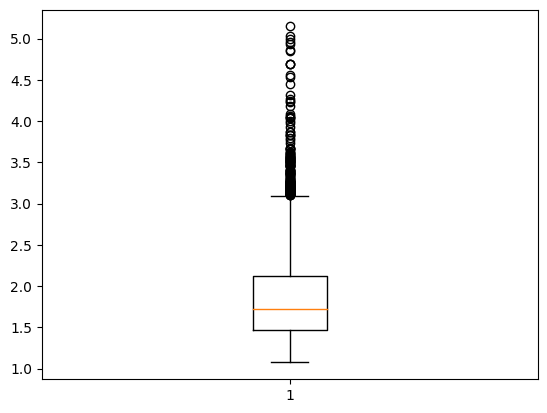

In [6]:
def snr(x):
    if x.mean() == 0:
        return 0
    return x.max() / x.mean()

snrs_raw = [snr(x) for x in frames_near0]
import matplotlib.pyplot as plt

plt.boxplot(snrs_raw)

In [7]:
from tensorflow.keras import layers, Sequential
import seaborn as sns
fig = plt.figure(figsize=(8,3))

def gen_aug_data(imgs, args):

    extra_aug = Sequential([], name='extra_aug')
    # extra_aug.add(RandomGaussianNoise(mean_range=(0, 0.2), std_range=(0.2, 0.8)))
    # extra_aug.add(layers.GaussianNoise(stddev=args['aug_gauss'], seed=args['seed']))
    extra_aug.add(layers.RandomBrightness(args['aug_brightness'], value_range=[0, 1], seed=args['seed']))
    
    
    aug_imgs = extra_aug(imgs[:, :, :, np.newaxis], training=True).numpy()
    return aug_imgs

# snrs_aug = np.array([snr(x) for x in aug_imgs])
# snrs_aug = snrs_aug[~np.isnan(snrs_aug)]
# sns.boxplot((snrs_raw, snrs_aug))


<Figure size 800x300 with 0 Axes>

In [8]:

# fig, axs = plt.subplots(5,5, figsize=(10, 10))
# for i, min_b in enumerate(np.linspace(-0.05, 0, 5)):
#     for i2, max_b in enumerate(np.linspace(0, 0.05, 5)):
#         args = {
#             'aug_gauss': 0.01,
#             'aug_brightness': (min_b, max_b),
#             'seed': np.random.randint(0, 25)
#         }
#         aug_imgs = np.concatenate([gen_aug_data(frames_near0, args) for _ in range(2)])
#         dfs = []
    
#         for ds, label in ((timelapse_spots, 'timelapse'), (frames_near0, 'raw'), (aug_imgs.squeeze(), 'aug')):
#             max_px = ds.max(axis=(1,2))
#             mean_px = ds.mean(axis=(1,2))
#             df = pd.DataFrame.from_dict({'mean': mean_px, 'max': max_px})
#             snrs = [snr(x) for x in ds]
            
#             df['group'] = label
#             dfs.append(df)
#             df['snr'] = snrs
        
#         df = pd.concat(dfs)
#         # sns.scatterplot(data=df, x='mean', y='max', hue='group', ax=axs[i][i2], legend=i+i2==0)
#         sns.histplot(data=df, x='snr', hue='group', ax=axs[i][i2], legend=i+i2==0, stat='frequency')
#         axs[i][i2].set_title(f'{str(round(min_b, 3))},{str(round(max_b, 3))}')
# fig.tight_layout()
# plt.show()


2024-06-28 10:50:44.341975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-28 10:50:44.342002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: ma-mdb119
2024-06-28 10:50:44.342006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: ma-mdb119
2024-06-28 10:50:44.342120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 555.42.2
2024-06-28 10:50:44.342134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 555.42.2
2024-06-28 10:50:44.342138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 555.42.2

KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x75253a60f600> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7524c94e40e0> (for post_execute):



KeyboardInterrupt



In [106]:


def norm_zero_one(x):
    return (x - x.min()) / (x.max() - x.min())

factors = []

def random_gauss(img, min_gauss, max_gauss):
    for i in range(img.shape[0]):
        if min_gauss == 0 and max_gauss == 0:
            continue
        x = np.random.uniform(min_gauss, max_gauss)
        noise = np.random.normal(x, 0.0001, size=img[i].shape)
        img[i] += noise
    return np.clip(img, 0, 1)

def random_brightness(img, min_brightness, max_brightness):
    for i in range(img.shape[0]):
        x = np.random.uniform(min_brightness, max_brightness)
        img[i] += x
    return np.clip(img, 0, 1)


def random_poisson(img, min_scale, max_scale):
    dtype = img.dtype
    for i in range(img.shape[0]):
        scale_factor = np.random.uniform(min_scale, max_scale)  # Adjust this to control noise level
        scaled_img = img[i] * scale_factor
        
        # Apply Poisson noise
        noisy_img = np.random.poisson(scaled_img.astype(int))
        
        # Convert back to original scale
        img[i] = (noisy_img / scale_factor).astype(dtype)
    return img
    
def random_noise(img, min_gauss, max_gauss, min_brightness, max_brightness, min_poisson, max_poisson):
    if min_gauss != 0 and max_gauss != 0:
        img = random_gauss(img, min_gauss, max_gauss)
    if min_brightness != 0 and max_brightness != 0:
        img = random_brightness(img, min_brightness, max_brightness)
    if min_poisson != 0 and max_poisson != 0:
        img = random_poisson(img, min_poisson, max_poisson)
    return img


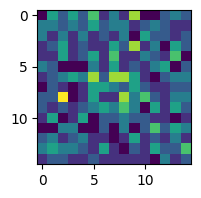

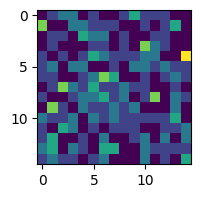

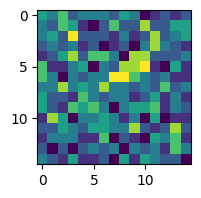

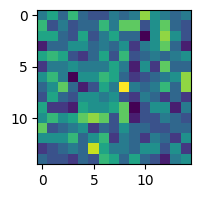

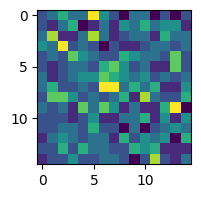

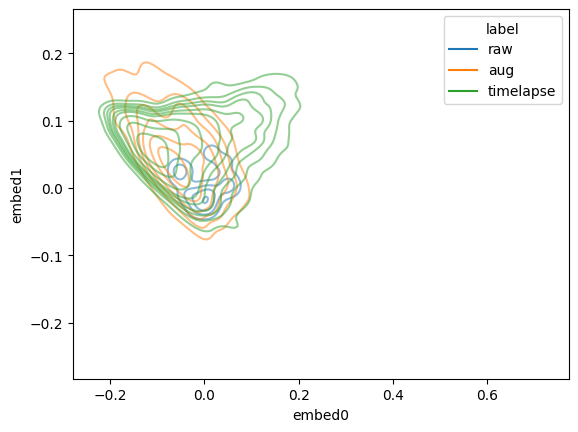

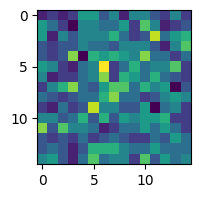

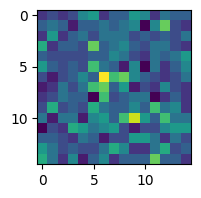

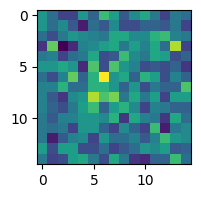

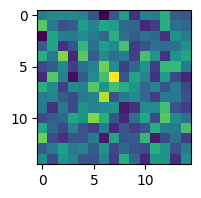

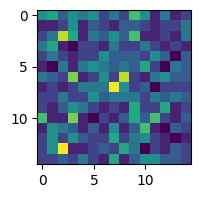

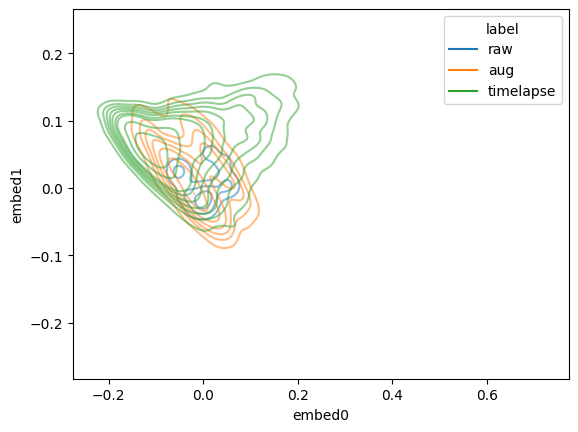

In [130]:
from sklearn.decomposition import PCA

frames_near0_subset = np.array(frames_near0[0:200])

def eval_argset(args, data):
    aug_imgs = np.concatenate([random_noise(np.array(data), *args['aug_gauss'], *args['aug_brightness'], *args['aug_poisson']) for _ in range(10)])
    for i in range(5):
        plt.figure(figsize=(2,2))
        plt.imshow(aug_imgs[i])
        plt.show()
    dfs = []
    
    pca = PCA().fit(data.reshape((data.shape[0], -1)))
    
    for ds, label in (
            (data, 'raw'), 
            (aug_imgs.squeeze(), 'aug'),
            (timelapse_spots, 'timelapse'), 
        ):
        ds = ds.reshape((ds.shape[0], -1))
        embed = pca.transform(ds)
        
        df = pd.DataFrame.from_dict({'embed0': embed[:, 0], 'embed1': embed[:, 1]})
        df['label'] = label
        dfs.append(df)
    
    df = pd.concat(dfs)
    sns.kdeplot(data=df, x='embed0', y='embed1', hue='label', alpha=0.5)
    plt.show()


args = {
    'aug_gauss': (-0.005, 0.005),
    'aug_brightness': (0, 0),
    'aug_poisson': (50, 200),
    'seed': np.random.randint(0, 25)
}
eval_argset(args, frames_near0_subset)

args = {
    'aug_gauss': (-0.005, 0.005),
    'aug_brightness': (0, 0),
    'aug_poisson': (50, 1000),
    'seed': np.random.randint(0, 25)
}
eval_argset(args, frames_near0_subset)


-0.0035335888000204273
-0.008759196189972668
-0.003142029201708002
-0.0037360873136956223
-0.003901809754901825
-0.005488047614561319
-0.005890961866044536
-0.003891571562026432
-0.00650909754196696
-0.0044151245020344265
-0.0058363203439847034
-0.004340151081881508
-0.0031006856211479735
-0.021518940536765483
-0.012687946130442312
-0.004494714538734795
-0.007591962910688337
-0.004629565384972928
-0.00710413393356758
-0.004879922338477437
-0.004876101424932154
-0.020251971388600343
-0.02427204543495314
-0.009433312445570377
-0.002806225365090264
-0.007762425160734385
-0.00588430954335432
-0.0070414626908215745
-0.0070040899895659255
-0.013799473532240616
-0.0068408647955473375
-0.006217443543114779
-0.008555332825388647
-0.0050224734184428615
-0.005398360525627572
-0.0030070774367993228
-0.006478466464012403
-0.008916221786242223
-0.007502342430324085
-0.00954980159900993
-0.005190569120181918
-0.00667682806600418
-0.006090792328241505
-0.00824096915722152
-0.00900172424113781
-0.00448

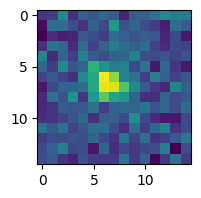

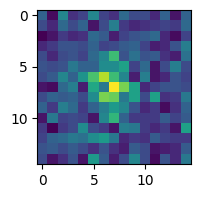

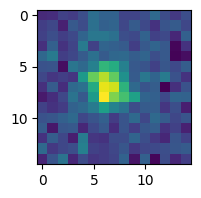

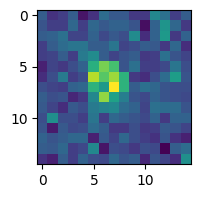

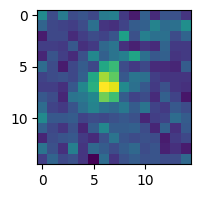

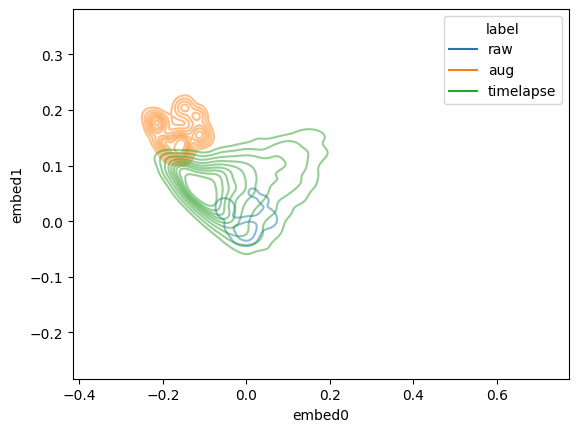

In [137]:
import numpy as np
from scipy.stats import wasserstein_distance
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args


frames_near0_subset = np.array(frames_near0[0:200])

# Load your datasets
original_data = np.array(frames_near0_subset) # Replace with your data loading function
target_data = np.array(timelapse_spots)      # Replace with your data loading function


pca = PCA().fit(timelapse_spots.reshape((timelapse_spots.shape[0], -1)))
                
# Define the feature extraction function
def get_features(data):
    return pca.transform(data.reshape((data.shape[0], -1)))

target_features = get_features(target_data)

# Define the similarity metric
def compute_similarity(features1, features2):
    # Compute Wasserstein distance for each feature dimension
    distances = [wasserstein_distance(f1, f2) for f1, f2 in zip(features1.T, features2.T)]
    # Return negative mean distance (to maximize similarity)
    return -np.mean(distances)

# Define the parameter space
param_space = [
    Real(-0.01, 0.01, name='brightness'),
    Real(-0.005, 0.005, name='gaussian'),
    Integer(10, 11, name='poisson_min'),
    Integer(100, 10000, name='poisson_max'),
]

def augment_data(data, brightness, poisson_min, poisson_max, gaussian):
    return random_noise(data, gaussian, gaussian, brightness, brightness, poisson_min, poisson_max)
    
# Objective function to maximize
@use_named_args(param_space)
def objective(**params):
    # Augment the original data using the current parameters
    augmented_data = augment_data(original_data, **params)
    
    # Extract features from both datasets
    augmented_features = get_features(augmented_data)
    
    
    # Compute similarity
    similarity = compute_similarity(augmented_features, target_features)
    print(similarity)
    return -similarity  # gp_minimize minimizes, so we return negative similarity

# Run Bayesian optimization
result = gp_minimize(objective, param_space, n_calls=200, random_state=0)

# Print the best parameters and similarity
print("Best parameters:")
best_args = {}
for param, value in zip(param_space, result.x):
    print(f"{param.name}: {value}")
    best_args[param.name] = value
print(f"Best similarity: {-result.fun}")
print(best_args)
argset = {
    'aug_brightness': (best_args['brightness'], best_args['brightness']),
    'aug_gauss': (best_args['gaussian'], best_args['gaussian']),
    'aug_poisson': (best_args['poisson_min'], best_args['poisson_max']),
}
eval_argset(argset, frames_near0_subset)



In [144]:
tmp = pd.read_hdf('/home/miguel/Projects/smlm_z/autofocus/VIT_zeiss_lowsnr_data/out_resnet_fov-max_aug11/out_nup/locs_3d.hdf5', key='locs')
sns.scatterplot(data=tmp, x='x', y='y', hue='group')
plt.show()
tmp = pd.read_hdf('/media/Backup/smlm_z_data/20240625_NUP_ifluor647/FOV1/storm_1/storm_1_MMStack_Default.ome_locs_undrift.hdf5', key='locs')
sns.scatterplot(data=tmp, x='x', y='y')
plt.show()

/home/miguel/anaconda3/envs/smlm_z/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'z [nm]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/miguel/anaconda3/envs/smlm_z/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'x [nm]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/miguel/anaconda3/envs/smlm_z/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'y [nm]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this obje

ValueError: Could not interpret value `group` for `hue`. An entry with this name does not appear in `data`.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def norm_imgs(imgs, img_norm):
    imgs_xy, z = _apply_img_norm((imgs, _), None, img_norm)
    return imgs_xy[0].numpy()

def tamper_img(img, mean, stdev):
    img += np.random.normal(0, 0.01, size=img.shape)
    img = (img * 65535).astype(int)
    noise = np.random.poisson(img, size=img.shape)
    show_psf_axial(noise-img, 'noise-img', 15)
    img += (noise * 2)
    img = img.astype(float)
    img /= 65535
    return img 



def eval_img(img, label, inter='bicubic'):
    xy = np.zeros((img.shape[0], 2))
    # show_psf_axial(img, '', 15)
    # plt.plot(img.max(axis=(1,2)) / img.mean(axis=(1,2)))
    # plt.show()

    img = apply_resizing((img[:, :, :, np.newaxis], xy), None, inter)[0][0]
    img = norm_imgs(np.array(img), img_norm)
    z_pred = model.predict((img, xy), verbose=False).squeeze() * 1000
    return z_pred, label
    

# for s in stacks[2:]:

#     res = [eval_img(s, 'original')]

#     for i in np.linspace(0, 0.1, 5):
#         img2 = tamper_img(np.array(s), i, 25)
#         res.append(eval_img(img2, str(round(i, 2))))

    
#     for z, label in res:
#         sns.lineplot(x=list(range(-1000, 1000, 10)), y=z, label=label)
#     plt.show()

#     break


i = 0
for s in stacks[2:]:
    plt.figure(figsize=(10,5))
    for inter in ("bilinear", "bicubic"):
        z_pred = eval_img(s, '', inter)[0]
        plt.plot(z_pred, label=inter)

    plt.legend()
    plt.show()
    i += 1
    if i > 5:
        break
        
    

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Sequential

def norm_imgs(imgs, img_norm):
    imgs_xy, z = _apply_img_norm((imgs, _), None, img_norm)
    return imgs_xy[0].numpy()

def tamper_img(img, mean, stdev):
    return img + np.random.normal(0, mean * img.max(), s.shape)


aug_pipeline = Sequential([], name='extra_aug')

GAUSS = 0.01
BRIGHTNESS = 0.1
# extra_aug.add(RandomGaussianNoise(mean_range=(0, 0.2), std_range=(0.2, 0.8)))
aug_pipeline.add(layers.RandomBrightness((-BRIGHTNESS, 0.1), value_range=[0, 1], seed=42))
aug_pipeline.add(layers.GaussianNoise(stddev=GAUSS, seed=42))

def filter_imgs(imgs, xy):
    stds = np.std(imgs, axis=(1, 2, 3))
    idx = np.argwhere(stds > 0.0005)[:, 0]
    z = np.arange(-1000, 1000, 10)
    print(imgs.shape, z.shape)
    return imgs[idx], xy[idx], z[idx]
                  
def tf_tamper_img(img):
    return aug_pipeline(img).numpy()

def snr(x):
    # print(x.max(), x.mean(), x.max() / x.mean(), str(round(x.std(), 10)))
    # if x.max() / x.mean() > 100:
    #     plt.imshow(x / x.max())
    #     plt.title(f'{str(round(x.max(), 3))}, {str(round(x.min(), 3))} {str(round(x.std(), 10))}')
    #     plt.show()
    return x.max() / x.mean()
    
def eval_img(img, label):
    xy = np.zeros((img.shape[0], 2))

    img = apply_resizing((img[:, :, :, np.newaxis], xy), None)[0][0].numpy()
    img = norm_imgs(np.array(img), img_norm)
    img = aug_pipeline(img).numpy()
    img, xy, z = filter_imgs(img, xy)
    show_psf_axial(img.mean(axis=-1), '', 15)
    # img[img<0] = 0
    # img[img>1] = 1
    z_pred = model.predict((img, xy), verbose=False).squeeze() * 1000
    snrs = [snr(x) for x in img]
    return z_pred, z, snrs, label
    

for s in stacks[2:]:

    res = [eval_img(s, 'original')]
    

    for i in range(5):
        # img2 = tamper_img(s, i, 25)
        res.append(eval_img(s, str(i)))


    z_preds = np.concatenate([x[0] for x in res])
    z_trues = np.concatenate([x[1] for x in res])
    snrs = np.concatenate([x[2] for x in res])
    idx = np.argwhere(snrs < 5)[:, 0]
    z_preds = z_preds[idx]
    z_trues = z_trues[idx]
    snrs = snrs[idx]
    
    sns.scatterplot(x=z_trues, y=z_preds, hue=snrs)
    plt.show()

    break
    